# Dutch Corpora

In [1]:
# Install tempo-embeddings from GitHub
# This can also refer to a specific version or branch

# %pip install --upgrade pip  # Required for properly resolving dependencies
# %pip uninstall -y tempo_embeddings  # Remove existing installation
# %pip install --upgrade git+https://github.com/Semantics-of-Sustainability/tempo-embeddings.git
%pip install -e ../
%pip install chromadb

Obtaining file:///Users/jose/Repos/tempo-embeddings
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tempo_embeddings (pyproject.toml) ... done
  Created wheel for tempo_embeddings: filename=tempo_embeddings-0.0.1-0.editable-py3-none-any.whl size=8953 sha256=90e5e38b391527fdc405e5d8d0745771ffddb75e501dbdcb347c796520fe81d1
  Stored in directory: /private/var/folders/79/zf67ls7520x9m4mj7nx6q07w0000gp/T/pip-ephem-wheel-cache-doiqwpgm/wheels/de/25/96/d92b7a130b730e0ab67770d76841f36cb3d1f9cda32a4a539b
Successfully built tempo_embeddings
  Attempting uninstall: tempo_embeddings
    Found existing installation: tempo_embeddings 0.0.1
    Uninstalling tempo_embeddings-0.0.1:
      Successfully uninstalled tempo_embeddings-0.0.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
# make sure installation has succeeded
import tempo_embeddings

In [3]:
%load_ext autoreload

In [4]:
try:
    import google.colab

    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False

## Load Database

In [5]:
%autoreload now

from pathlib import Path
from tqdm import tqdm
from tempo_embeddings.text.corpus import Corpus

/Users/jose/Repos/tempo-embeddings/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jose/Repos/tempo-embeddings/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from tempo_embeddings.embeddings.vector_database import ChromaDatabaseManager

MODEL_NAME = "NetherlandsForensicInstitute/robbert-2022-dutch-sentence-transformers"
FILTER_TERMS = ["duurzaam"]

db = ChromaDatabaseManager(db_path="testing_db", embedder_name=MODEL_NAME, batch_size=10)
db.connect()

collection_name = "anp_sg_corpus"

anp_sg_corpus = Corpus.from_chroma_db(db, collection_name=collection_name, filter_terms=FILTER_TERMS)

Database Path 'testing_db' already exists. Loading current configuration
{'embedder_name': 'NetherlandsForensicInstitute/robbert-2022-dutch-sentence-transformers', 'embedder_type': 'hf', 'existing_collections': ['anp_sg_corpus']}
Wordt er ook verder verduurzaamd in Nederland, zodat er minder gas hoeft te worden gebruikt? Hoe gaat de minister dat realiseren? Voorzitter. Ik kom op de afhandeling van schade. In Nederland is het gewoon <class 'str'>
motie-Wassenberg/Beckerman op stuk nr. 17 roept mij tot niets op, maar het is volledig aan de Kamer. Die zou dan uitspreken dat restwarmte niet duurzaam is. Mijn repliek zou zijn dat het weggooien van <class 'str'>
kunnen komen. We weten allemaal dat het een van de grootste opgaven van dit kabinet en ons allen is om de klimaatdoelstellingen van Parijs te halen. Dat betekent dat ook duurzaamheid eigenlijk niet langer <class 'str'>
wat onduurzaam is, zoals vlees en zuivel, kunnen we de btw juist gaan verhogen. Dan krijg je positieve gedragsverand

In [7]:
for p in anp_sg_corpus.passages[:20]:
    print(len(p), p)

corpus = anp_sg_corpus

print(corpus.embeddings.shape)

205 Passage('Wordt er ook verder verduurzaamd in Nederland, zodat er minder gas hoeft te worden gebruikt? Hoe gaat de minister dat realiseren? Voorzitter. Ik kom op de afhandeling van schade. In Nederland is het gewoon', {'': '172', 'RecId': 'h-tk-20172018-39-7', 'chamber': 'TweedeKamer', 'datapoint_x': 9.886270523071289, 'datapoint_y': 5.5951056480407715, 'date': '2018-01-16', 'speakers': 'De voorzitter :|De voorzitter :|Mevrouw Van Tongeren ( GroenLinks ):|De voorzitter :|De heer Wassenberg ( PvdD ):|De voorzitter :|Mevrouw Beckerman ( SP ):|Mevrouw Beckerman ( SP ):|De voorzitter :|Mevrouw Yeşilgöz-Zegerius ( VVD ):|De voorzitter :|Mevrouw Beckerman ( SP ):|Mevrouw Yeşilgöz-Zegerius ( VVD ):|Mevrouw Beckerman ( SP ):|Mevrouw Yeşilgöz-Zegerius ( VVD ):|De voorzitter :|Mevrouw Yeşilgöz-Zegerius ( VVD ):|De voorzitter :|Mevrouw Beckerman ( SP ):|Mevrouw Yeşilgöz-Zegerius ( VVD ):|Mevrouw Sazias ( 50PLUS ):|Mevrouw Yeşilgöz-Zegerius ( VVD ):|Mevrouw Sazias ( 50PLUS ):|Mevrouw Yeşilgöz-Z

## Read Stopwords

In [8]:
!wget --continue https://raw.githubusercontent.com/Semantics-of-Sustainability/tempo-embeddings/main/tempo_embeddings/data/stopwords-filter-nl.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
zsh:1: command not found: wget


In [9]:
stopwords_file = Path("stopwords-filter-nl.txt")

with open(stopwords_file.absolute(), "rt") as f:
    stopwords = set(f.read().splitlines())

stopwords.update(
    {
        "wij",
        "we",
        "moeten",
        "heer",
        "mevrouw",
        "minister",
        "voorzitter",
        "gaat",
        "wel",
        "den",
    }
)

## Cluster

In [10]:
%autoreload now

# Arguments: min_cluster_size=10, cluster_selection_epsilon=0.1, ...
# See https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html for full list

# e.g. min_samples=10, cluster_selection_epsilon=0.2, cluster_selection_method="leaf"

clusters = corpus.cluster(min_cluster_size=10, cluster_selection_epsilon=0.1)
print(clusters)

[Subcorpus(14, [0, 22, 42, 48, 55, 60, 62, 63, 68, 91]), Subcorpus(-1, [1, 2, 5, 18, 36, 38, 40, 45, 49, 50]), Subcorpus(5, [3, 31, 52, 77, 136, 198, 232, 291, 320, 332]), Subcorpus(0, [4, 44, 47, 110, 190, 210, 234, 244, 281, 321]), Subcorpus(8, [6, 12, 129, 144, 169, 214, 224, 264, 269, 305]), Subcorpus(17, [7, 11, 13, 14, 16, 17, 19, 20, 24, 25]), Subcorpus(4, [8, 21, 56, 67, 100, 131, 133, 145, 189, 206]), Subcorpus(20, [9, 117, 123, 166, 831, 842, 971, 1017, 1126, 1167]), Subcorpus(9, [10, 70, 95, 104, 122, 146, 149, 160, 184, 238]), Subcorpus(6, [15, 72, 81, 102, 132, 140, 277, 333, 335, 391]), Subcorpus(13, [23, 80, 121, 162, 163, 165, 230, 256, 279, 286]), Subcorpus(3, [26, 155, 188, 236, 255, 311, 345, 398, 405, 407]), Subcorpus(19, [32, 65, 69, 106, 235, 242, 324, 512, 747, 814]), Subcorpus(11, [46, 247, 292, 317, 577, 600, 787, 788, 998, 1002]), Subcorpus(10, [54, 108, 171, 173, 266, 447, 475, 576, 610, 763]), Subcorpus(15, [59, 90, 176, 180, 205, 228, 259, 299, 304, 307]), 

In [11]:
for cluster in clusters:
    cluster.set_topic_label(exclude_words=frozenset(stopwords | set(FILTER_TERMS)), n=5)
    print(cluster)

Subcorpus('energie; biomassa; gas; duurzame; gaan', [0, 22, 42, 48, 55, 60, 62, 63, 68, 91])
Subcorpus('Outliers', [1, 2, 5, 18, 36, 38, 40, 45, 49, 50])
Subcorpus('voedsel; gezond; eten; d66; vlees', [3, 31, 52, 77, 136, 198, 232, 291, 320, 332])
Subcorpus('herstel; wereldeconomie; red; tijd; eigen', [4, 44, 47, 110, 190, 210, 234, 244, 281, 321])
Subcorpus('vervoer; blokje; spoor; innovaties; nodig', [6, 12, 129, 144, 169, 214, 224, 264, 269, 305])
Subcorpus('duurzaamheid; motie; gaan; heel; goed', [7, 11, 13, 14, 16, 17, 19, 20, 24, 25])
Subcorpus('warmte; warmtenetten; warmtenet; warmtevoorziening; warmtewet', [8, 21, 56, 67, 100, 131, 133, 145, 189, 206])
Subcorpus('monitor; nederland; welvaart; brede; verantwoordingsdebat', [9, 117, 123, 166, 831, 842, 971, 1017, 1126, 1167])
Subcorpus('handel; duurzaamheidshoofdstuk; handelsverdragen; afspraken; japan', [10, 70, 95, 104, 122, 146, 149, 160, 184, 238])
Subcorpus('boeren; duurzaamheid; landbouw; onze; waar', [15, 72, 81, 102, 132,

/Users/jose/Repos/tempo-embeddings/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [12]:
with open("clusters.txt", "wt") as f:
    for cluster in clusters:
        print(
            ", ".join(
                cluster.top_words(
                    exclude_words=frozenset(stopwords | set(FILTER_TERMS)), n=5
                )
            ),
            file=f,
        )

# Visualize Embeddings

<Axes: xlabel='x', ylabel='y'>

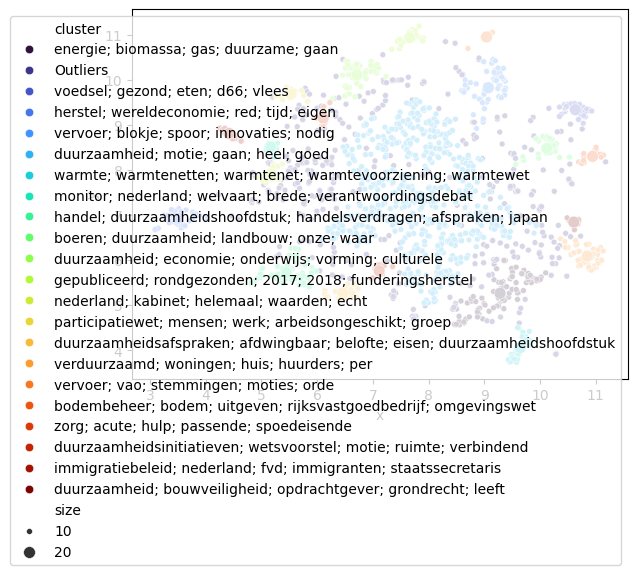

In [13]:
%autoreload now

from tempo_embeddings.visualization.clusters import ClusterVisualizer

visualizer = ClusterVisualizer(*clusters)
visualizer.visualize()

In [14]:
import os
from bokeh.io import output_notebook
from bokeh.io import reset_output
from bokeh.plotting import show
from tempo_embeddings.visualization.bokeh import BokehInteractiveVisualizer


output_notebook()
# reset_output()

visualizer = BokehInteractiveVisualizer(
    *clusters, metadata_fields=corpus.metadata_fields(), width=2000, height=1000
)

os.environ[
    "BOKEH_ALLOW_WS_ORIGIN"
] = "*"

show(visualizer.create_document)

Loading BokehJS ...